## Import dependencies

In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import scipy as sp
from tqdm import tqdm
import glob
import xarray as xr

sys.path.append('../../')
from FaIRv2_0_0_alpha import *
from scripts.stats import *

%matplotlib inline

# Calculation of the global warming index

Here we compute an estimate of the present-day contribution of anthropogenic forcing to the observed change in Global Mean Surface Temperature, taking key uncertainties into account. This estimate follows the methodology of Haustein et al., 2017.

References:

Haustein, K., Allen, M. R., Forster, P. M., Otto, F. E. L., Mitchell, D. M., Matthews, H. D., & Frame, D. J. (2017). A real-time Global Warming Index. Scientific Reports, 7(1), 15417. https://doi.org/10.1038/s41598-017-14828-5

## Generate forcing shapes
Here we generate a wide range of anthropogenic and natural forcing timeseries, sampling uncertainties in each component independently following Forster et al., 2013.

References:

Forster, P. M., Andrews, T., Good, P., Gregory, J. M., Jackson, L. S., & Zelinka, M. (2013). Evaluating adjusted forcing and model spread for historical and future scenarios in the CMIP5 generation of climate models. Journal of Geophysical Research: Atmospheres, 118(3), 1139–1150. https://doi.org/10.1002/jgrd.50174

Myhre, G., Shindell, D., Bréon, F.-M., Collins, W., Fuglestvedt, J., Huang, J., … Zhang, H. (2013). Anthropogenic and Natural Radiative Forcing. In T. F. Stocker, D. Qin, G.-K. Plattner, M. Tignor, S. K. Allen, J. Boschung, … P. M. Midgley (Eds.), Climate Change 2013: The Physical Science Basis. Contribution of Working Group I to the Fifth Assessment Report of the Intergovernmental Panel on Climate Change (pp. 659–740). https://doi.org/10.1017/CBO9781107415324.018

In [2]:
## import base data:
erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_ssp245_1750-2500.csv',index_col=0,dtype=float)
erf_ar6 -= erf_ar6.loc[1750]

## update ozone to Skeie et al. 2021
def get_skeie_ts(fname):
    data = pd.read_csv(fname,skiprows=3,sep=';',index_col=0)['NET adj.']
    data.index = [int(x[:4]) for x in data.index]
    data.name = fname.split('/')[-1].split('_')[2]
    return data/1000

skeie_files = glob.glob('../../aux/input-data/_hidden/histO3/Kernel_output/TotRF/CMIP6/*.csv')

skeie_o3_data = pd.concat([get_skeie_ts(x) for x in skeie_files],axis=1)

oslo_CTM_data = get_skeie_ts('../../aux/input-data/_hidden/histO3/Kernel_output/TotRF/OsloCTM3/RF_NRFmethod_OsloCTM3_net_yearly.csv')
skeie_o3_data = pd.concat([skeie_o3_data,oslo_CTM_data],axis=1)

good_models = ['BCC-ESM1', 'CESM2-WACCM', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']

# take multi-model mean of "good" models
skeie_o3_ts = skeie_o3_data[good_models].mean(axis=1).replace(np.nan,0)
skeie_o3_ts.loc[1750] = -0.03
skeie_o3_ts -= skeie_o3_ts.loc[1750]
skeie_o3_ts.sort_index(inplace=True)

# remove OsloCTM3 bias relative to MMM for 2014-> data
skeie_o3_ts.loc[2014:] += skeie_o3_data.loc[2010,good_models].mean() - skeie_o3_data.loc[2010,'OsloCTM3']

## combine & drop previous ozone estimates
erf_ar6 = erf_ar6.loc[1750:2019]
erf_ar6.loc[:,'ozone'] = skeie_o3_ts.reindex(np.arange(1750,2021)).interpolate().loc[1750:2019]
erf_ar6.drop(['o3_tropospheric','o3_stratospheric'],axis=1,inplace=True)

In [3]:
## creating a forcing response dataset

def generate_forcing(N):
    
    ## generating many rf shapes for the GWI

    rf_factors = {}

    rf_factors['co2'] = sp.stats.norm(1,0.20/1.645).rvs(N)
    rf_factors['ch4'] = sp.stats.norm(1,0.28/1.645).rvs(N)
    rf_factors['n2o'] = sp.stats.norm(1,0.2/1.645).rvs(N)
    rf_factors['other_wmghg'] = sp.stats.norm(1,0.20/1.645).rvs(N)
    rf_factors['ozone'] = sp.stats.norm(1,0.5/1.645).rvs(N)
    rf_factors['h2o_stratospheric'] = sp.stats.norm(1,0.72/1.645).rvs(N)
    rf_factors['contrails'] = sp.stats.norm(1,0.75/1.645).rvs(N)
    rf_factors['land_use'] = sp.stats.norm(1,0.75/1.645).rvs(N)
    rf_factors['volcanic'] = sp.stats.norm(1,0.5/1.645).rvs(N)
    rf_factors['solar'] = sp.stats.norm(1,1/1.645).rvs(N)

    pct_5 = 0.04 / 0.08
    pct_95 = 0.18 / 0.08
    sigma = (np.log(pct_95) - np.log(pct_5)) / (sp.stats.norm().ppf(0.95)-sp.stats.norm().ppf(0.05))
    mu = np.log(pct_5) - sigma * sp.stats.norm().ppf(0.05)
    rf_factors['bc_on_snow'] = sp.stats.lognorm(s=sigma,scale=np.exp(mu)).rvs(N)

    ant_rf_ensemble = np.zeros((270,N))
    nat_rf_ensemble = np.zeros((270,N))

    for agent in ['co2','ch4','n2o','other_wmghg','ozone','h2o_stratospheric','contrails','land_use','bc_on_snow']:
        ant_rf_ensemble += rf_factors[agent]*erf_ar6.loc[1750:2019,agent].values[:,None]

    for agent in ['volcanic','solar']:
        nat_rf_ensemble += rf_factors[agent]*erf_ar6.loc[1750:2019,agent].values[:,None]

    ## aerosol distribution 

    ERFari_shape = erf_ar6.loc[1750:2019,['aerosol-radiation_interactions']].values.T
    ERFaci_shape = erf_ar6.loc[1750:2019,['aerosol-cloud_interactions']].values.T

    ## construct the Smith distributions 
    def fit_skewnorm(x,X,percentiles):
        distr = sp.stats.skewnorm(*x)
        return sum(abs(distr.ppf(percentiles) - X))

    ERFaci_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.13,0.59,1.17],[0.05,0.5,0.95]),method='nelder-mead').x
    ERFari_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.07,0.27,0.6],[0.05,0.5,0.95]),method='nelder-mead').x

    ERFaci_smith_sknorm_distr = -1*sp.stats.skewnorm(*ERFaci_smith_sknorm_params).rvs(N)[:,None]
    ERFari_smith_sknorm_distr = -1*sp.stats.skewnorm(*ERFari_smith_sknorm_params).rvs(N)[:,None]

    ERFari_samples = ERFari_smith_sknorm_distr / ERFari_shape[0,-1] * ERFari_shape
    ERFaci_samples = ERFaci_smith_sknorm_distr / ERFaci_shape[0,-1] * ERFaci_shape
    
    tot_aer = (ERFari_samples+ERFaci_samples).T

    ## Combine all anthro forcings
    ant_rf_ensemble += tot_aer
    
    ## 
    rf_nat = pd.DataFrame(nat_rf_ensemble,index=np.arange(1750,2020),columns=pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(N)],['forcing']])).loc[:2019]

    rf_ant = pd.DataFrame(ant_rf_ensemble,index=np.arange(1750,2020),columns=pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(N)],['forcing']])).loc[:2019]
    
    return rf_ant,rf_nat

<AxesSubplot:>

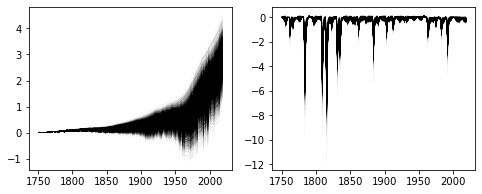

In [4]:
# set the number of forcing shapes to use
N_forc = 5000

rf_ant,rf_nat = generate_forcing(N_forc)

fig,ax = plt.subplots(1,2,figsize=(8,3))

rf_ant.plot(ax=ax[0],lw=0.02,c='k',legend=None)
rf_nat.plot(ax=ax[1],lw=0.02,c='k',legend=None)

## Generate response parameters
Here we generate a range of response model parameters, aiming to sample the full range of behaviours exhibited. To do this, we sample a range of response timescales, and realised warming fractions. These ranges correspond approximately to the parameter ranges observed within CMIP5/6.

In [5]:
def generate_response_params():

    ## create the response parameter ranges:

    ### based on inferred ranges from CMIP6 - 18 combinations total
    response_names = ['response_'+str(x) for x in np.arange(24)]
    response_params = pd.DataFrame(index=['d','q'],columns = pd.MultiIndex.from_product([response_names,[1,2,3]])).apply(pd.to_numeric)
    response_params.loc[:] = 0

    d1_range = [0.2,0.8,1.4,2]
    d2_range = [4,8,12,16]
    d3_range = [100,200,400,800]
    q1_range = [0.04,0.16,0.28,0.4]

    RWF_range = [0.3 , 0.4 , 0.5, 0.6, 0.7, 0.8]
    ECS=3

    i=0
    for d_num in np.arange(4):
        for RWF in RWF_range:
            response_params.loc['d',(response_names[i],1)] = d1_range[d_num]
            response_params.loc['d',(response_names[i],2)] = d2_range[d_num]
            response_params.loc['d',(response_names[i],3)] = d3_range[d_num]
            response_params.loc['q',(response_names[i],1)] = q1_range[d_num]

            v1 = (1-(d1_range[d_num]/69.66) * (1-np.exp(-69.66/d1_range[d_num])) )
            v2 = (1-(d2_range[d_num]/69.66) * (1-np.exp(-69.66/d2_range[d_num])) )
            v3 = (1-(d3_range[d_num]/69.66) * (1-np.exp(-69.66/d3_range[d_num])) )
            
            TCR = RWF * ECS
            F_2x = 3.76
            
            q3 = (((TCR/F_2x) - q1_range[d_num]*(v1-v2) - (ECS/F_2x)*v2) / (v3-v2))
            q2 = (ECS/F_2x - q1_range[d_num] -  q3)

            response_params.loc['q',(response_names[i],2)] = q2
            response_params.loc['q',(response_names[i],3)] = q3

            i+=1

    ## remove any that are unphysical (negative parameters)

    response_params = response_params.reindex([i for i,x in ((response_params<0).sum().unstack().sum(axis=1)==1).iteritems() if not x],axis=1,level=0)
    
    return response_params

In [6]:
response_params = generate_response_params()

## Generate temperature profiles
Run the forcing shapes generated over the range of impulse-response model parameters.

In [7]:
## generate the temperature responses:

null_gas_params = pd.read_csv('../../aux/parameter-sets/Complete_gas_cycle_params.csv',header=[0,1],index_col=0).reindex(['carbon_dioxide'],axis=1,level=1)
##
temp_ant = run_FaIR(emissions_in=return_empty_emissions(rf_ant,gases_in=['carbon_dioxide']),gas_parameters=null_gas_params,forcing_in=rf_ant,thermal_parameters=response_params)['T'].droplevel(1,axis=1)
temp_nat = run_FaIR(emissions_in=return_empty_emissions(rf_nat,gases_in=['carbon_dioxide']),gas_parameters=null_gas_params,forcing_in=rf_nat,thermal_parameters=response_params)['T'].droplevel(1,axis=1)

Integrating 5000 scenarios, 1 gas cycle parameter sets, 18 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1750 and 2019...


100%|██████████| 269/269 [00:02<00:00, 95.69 timestep/s]


Integrating 5000 scenarios, 1 gas cycle parameter sets, 18 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1750 and 2019...


100%|██████████| 269/269 [00:02<00:00, 95.15 timestep/s]


### save temperature series to netcdfs for combination with OLSE coefficients later

In [8]:
xr.DataArray(temp_ant.values,
             dims=['time','index'],
             coords=dict(time=pd.to_datetime(temp_ant.index.astype('str')),index=temp_ant.columns)).unstack('index').rename({'Scenario':'forcing_mem','Thermal set':'response_mem'}).to_netcdf('../../aux/output-data/global-warming-index/ant_temperature.nc')

xr.DataArray(temp_nat.values,
             dims=['time','index'],
             coords=dict(time=pd.to_datetime(temp_ant.index.astype('str')),index=temp_ant.columns)).unstack('index').rename({'Scenario':'forcing_mem','Thermal set':'response_mem'}).to_netcdf('../../aux/output-data/global-warming-index/nat_temperature.nc')

### Retrieve CMIP6 internal variability & subsample

We generate many samples of internal variability from CMIP6 piControl simulations. We reject the samples if the drift is greater than 0.15 K / century. Overall, we generate 102 samples of internal variability of the same length as our observational GMST datasets, two samples (drawn at random from the piControl) from each of the 51 CMIP6 models available.

In [9]:
## computing the uncertainty from internal variability

def generate_IV(series_length=170):
    ### get internal variability timeseries:

    piControl_data = pd.read_csv('../../aux/input-data/CMIP6/piControl.csv',index_col=0)
    for i,x in enumerate(['source','member','variable']):
        piControl_data.loc[x] = [x.split('_')[i+1] for x in piControl_data.columns]

    CMIP6_int_var=piControl_data.T.set_index(['source','member','variable']).T.xs('tas',axis=1,level=-1).apply(pd.to_numeric)

    ### subsample 100 * 170 year slices
    ### check if drift, discard if drift > 0.15 K / century
    ### randomly pick one non-drifting sample

    CMIP6_int_var_samples = pd.DataFrame(index=np.arange(series_length))
    for model,data in CMIP6_int_var.iteritems():
        arr = data.dropna().values
        chunksize = arr.size
        if chunksize<series_length:
            continue
        starting_points = np.random.choice(np.arange(chunksize-series_length),100)
        nodrift_points = []
        for s in starting_points:
            subarr = arr[s:s+series_length]
            drift = sp.stats.linregress(np.arange(series_length),subarr).slope
            if abs(drift)*100>0.15:
                continue
            else:
                nodrift_points+=[s]
        chosen_start = np.random.choice(nodrift_points)
        index_name = '_'.join(list(model))+'_'+str(chosen_start)
        CMIP6_int_var_samples.loc[:,index_name] = arr[chosen_start:chosen_start+series_length] - arr[chosen_start:chosen_start+series_length].mean()

    ### remove model degeneracies (take first member of each model):
    models = []
    chosen_members = []
    for model,data in CMIP6_int_var_samples.dropna(axis=1).iteritems():
        if model.split('_')[0] in models:
            continue
        else:
            chosen_members+=[model]
            models+=[model.split('_')[0]]

    return CMIP6_int_var_samples[chosen_members]

<AxesSubplot:>

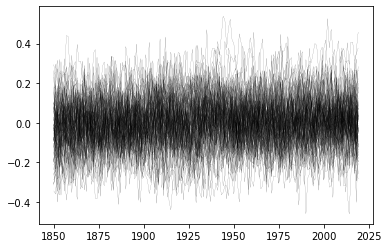

In [10]:
# 50 members seems insufficient to fully span the range of internal variability uncertainty, so we randomly sample from each model twice
CMIP6_int_var_samples_nondeg = pd.concat([generate_IV(),generate_IV()],axis=1)
CMIP6_int_var_samples_nondeg.index = np.arange(1850,2020)

CMIP6_int_var_samples_nondeg.plot(legend=None,lw=0.1,c='k')

## Choose and import the observational temperature dataset (updated to start of 2021)

Available datasets are below. We add uncertainty from the HadCRUT5 ensemble to non-ensemble products (GISTEMP, NOAA & Berkeley) as this represents the most conservative estimate of uncertainty.

[GISTEMP](https://data.giss.nasa.gov/gistemp/) - single series, augment with HadCRUT5 ensemble
- ERSSTv5 + GHCNv4

[NOAA](https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/) - single series, augment with HadCRUT5 ensemble
- ERSSTv5 + GHCNv4

[BERKELEY](http://berkeleyearth.org/data/) - singles series, augment with HadCRUT5 ensemble
- HadSST3 + Berkeley land

[CW](https://www-users.york.ac.uk/~kdc3/papers/coverage2013/series.html) - 99 (100) member ensemble
- infilled HadCRUT4

[HadCRUT5](http://data.ceda.ac.uk/badc/ukmo-hadobs/data/insitu/MOHC/HadOBS/HadCRUT/HadCRUT5/analysis/diagnostics) - 200 member ensemble
- HadSST4 + CRUTEM5

[HadCRUT4](https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/download.html) - 100 member ensemble
- HadSST3 + CRUTEM4

References:

Morice, C. P., Kennedy, J. J., Rayner, N. A., Winn, J. P., Hogan, E., Killick, R. E., … Simpson, I. R. (2020). An updated assessment of near‐surface temperature change from 1850: the HadCRUT5 dataset. Journal of Geophysical Research: Atmospheres. https://doi.org/10.1029/2019JD032361

Morice, C. P., Kennedy, J. J., Rayner, N. A., Jones, P. D., P., M. C., J., K. J., … D., J. P. (2011). Quantifying uncertainties in global and regional temperature change using an ensemble of observational estimates: The HadCRUT4 data set. Journal of Geophysical Research: Atmospheres, 117(D8). https://doi.org/10.1029/2011JD017187

Cowtan, K., & Way, R. G. (2014). Coverage bias in the HadCRUT4 temperature series and its impact on recent temperature trends. Quarterly Journal of the Royal Meteorological Society, 140(683), 1935–1944. https://doi.org/10.1002/qj.2297

Lenssen, N. J. L., Schmidt, G. A., Hansen, J. E., Menne, M. J., Persin, A., Ruedy, R., & Zyss, D. (2019). Improvements in the uncertainty model in the Goddard Institute for Space Studies Surface Temperature (GISTEMP) analysis. Journal of Geophysical Research: Atmospheres, 2018JD029522. https://doi.org/10.1029/2018JD029522

Vose, R. S., Arndt, D., Banzon, V. F., Easterling, D. R., Gleason, B., Huang, B., … Wuertz, D. B. (2012). NOAA’s Merged Land–Ocean Surface Temperature Analysis. Bulletin of the American Meteorological Society, 93(11), 1677–1685. https://doi.org/10.1175/BAMS-D-11-00241.1

Rohde, R. A., & Hausfather, Z. (2020). The Berkeley Earth Land/Ocean Temperature Record. Earth System Science Data, 12(4), 3469–3479. https://doi.org/10.5194/essd-12-3469-2020

In [11]:
def get_GMST(select_dataset):

    ## retrieve chosen dataset:
    if select_dataset == 'HadCRUT5':
        GMST = xr.open_dataset('../../aux/input-data/Temperature-observations/HadCRUT.5.0.1.0.analysis.ensemble_series.global.monthly.nc').tas.to_pandas().T
        GMST.columns.name = 'HadCRUT5_obs_mem'

    if select_dataset == 'HadCRUT4':
        GMST = pd.concat([pd.read_csv(x,header=None,delim_whitespace=True,index_col=0,usecols=[0,1]).iloc[:,0] for x in sorted(glob.glob('../../aux/input-data/Temperature-observations/HadCRUT.4.6.0.0.monthly_ns_avg_realisations/*.txt'))],axis=1,keys=np.arange(100))
        GMST.index = pd.to_datetime(GMST.index)
        GMST.columns.name = 'HadCRUT4_obs_mem'

    if select_dataset == 'NOAA':
        GMST = pd.read_csv('../../aux/input-data/Temperature-observations/aravg.mon.land_ocean.90S.90N.v5.0.0.202101.asc',delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
        GMST.index = pd.to_datetime(GMST.date.astype(str)+'-'+GMST.month.astype(str))
        unc = xr.open_dataset('../../aux/input-data/Temperature-observations/HadCRUT.5.0.1.0.analysis.ensemble_series.global.monthly.nc').tas.to_pandas().T
        unc = unc.sub(unc.median(axis=1),axis=0)
        GMST = (unc.loc['1880':'2020']+GMST.sort_index().loc['1880':'2020',['anom']].values)
        GMST.columns.name = 'HadCRUT5_obs_mem'

    if select_dataset == 'GISTEMP':
        GMST = pd.read_csv('../../aux/input-data/Temperature-observations/GLB.Ts+dSST.csv',skiprows=2,names=['year']+list(range(1,13)),usecols=range(13),index_col=0).unstack().reset_index()
        GMST.index = pd.to_datetime(GMST.year.astype(str)+'-'+GMST.level_0.astype(str))
        unc = xr.open_dataset('../../aux/input-data/Temperature-observations/HadCRUT.5.0.1.0.analysis.ensemble_series.global.monthly.nc').tas.to_pandas().T
        unc = unc.sub(unc.median(axis=1),axis=0)
        GMST = (unc.loc['1880':'2020']+GMST.sort_index().loc['1880':'2020',[0]].astype(float).values)
        GMST.columns.name = 'HadCRUT5_obs_mem'

    if select_dataset == 'CW':
        GMST=pd.read_csv('../../aux/input-data/Temperature-observations/had4_krig_ensemble_v2_0_0.txt',delim_whitespace=True,index_col=0,names=['date']+list(range(100)))
        GMST.index = pd.to_datetime(GMST.index.astype(int).astype(str)+'-'+np.ceil((GMST.index%1)*12).astype(int).astype(str))
        # current version of the dataset has a null member at 32
        GMST = GMST.drop(32,axis=1)
        GMST.columns.name = 'CW_obs_mem'

    if select_dataset == 'BERKELEY':
        # NB this uses air temps above sea ice, not water temps
        GMST = pd.read_csv('../../aux/input-data/Temperature-observations/Land_and_Ocean_complete.txt',skiprows=76,skipfooter=2057,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
        GMST.index = pd.to_datetime(GMST.date.astype(str)+'-'+GMST.month.astype(str))
        unc = xr.open_dataset('../../aux/input-data/Temperature-observations/HadCRUT.5.0.1.0.analysis.ensemble_series.global.monthly.nc').tas.to_pandas().T
        unc = unc.sub(unc.median(axis=1),axis=0)
        GMST = (unc.loc['1850':'2020']+GMST.sort_index().loc['1850':'2020',['anom']].values)
        GMST.columns.name = 'HadCRUT5_obs_mem'
        
    return GMST

In [12]:
def run_GWI(select_dataset,temp_ant,temp_nat):

    GMST = get_GMST(select_dataset)

    ## resample GMST to annual:

    GMST = GMST.resample('y').mean()
    GMST.index = GMST.index.year.astype(int)
    GMST = GMST.loc[:2019]
    
    # regress temps vs observed temps
    
    ant_coefs = np.empty((GMST.shape[1],temp_ant.shape[1]))
    nat_coefs = np.empty((GMST.shape[1],temp_nat.shape[1]))
    R2_vals = np.empty((GMST.shape[1],temp_ant.shape[1]))

    temp_vstack = np.array([temp_ant.loc[GMST.index].values,temp_nat.loc[GMST.index].values]).T

    for i in tqdm(np.arange(ant_coefs.shape[1])):
        _lreg = OLSE_NORM(temp_vstack[i],GMST.values)
        ant_coefs[:,i] = _lreg['coefs'][0]
        nat_coefs[:,i] = _lreg['coefs'][1]
        R2_vals[:,i] = _lreg['R2']
        
    ## save results
    
    xr.DataArray(ant_coefs,
                 dims=[GMST.columns.name,'index'],
                 coords={GMST.columns.name:GMST.columns,'index':temp_ant.columns}).unstack('index').rename({'Scenario':'forcing_mem','Thermal set':'response_mem'}).to_netcdf('../../aux/output-data/global-warming-index/ant_coefs_forc_'+select_dataset+'.nc')

    xr.DataArray(nat_coefs,
                 dims=[GMST.columns.name,'index'],
                 coords={GMST.columns.name:GMST.columns,'index':temp_nat.columns}).unstack('index').rename({'Scenario':'forcing_mem','Thermal set':'response_mem'}).to_netcdf('../../aux/output-data/global-warming-index/nat_coefs_forc_'+select_dataset+'.nc')
    
    xr.DataArray(R2_vals,
                 dims=[GMST.columns.name,'index'],
                 coords={GMST.columns.name:GMST.columns,'index':temp_nat.columns}).unstack('index').rename({'Scenario':'forcing_mem','Thermal set':'response_mem'}).to_netcdf('../../aux/output-data/global-warming-index/R2_forc_'+select_dataset+'.nc')
    
    
    ## regress temps vs IV
    
    ant_coefs_iv = np.empty((CMIP6_int_var_samples_nondeg.shape[1],temp_ant.shape[1]))
    nat_coefs_iv = np.empty((CMIP6_int_var_samples_nondeg.shape[1],temp_nat.shape[1]))
    R2_vals_iv = np.empty((CMIP6_int_var_samples_nondeg.shape[1],temp_nat.shape[1]))
    
    IV_regress = CMIP6_int_var_samples_nondeg.loc[GMST.index].values

    for i in tqdm(np.arange(ant_coefs_iv.shape[1])):
        _lreg = OLSE_NORM(temp_vstack[i],IV_regress)
        ant_coefs_iv[:,i] = _lreg['coefs'][0]
        nat_coefs_iv[:,i] = _lreg['coefs'][1]
        R2_vals_iv[:,i] = _lreg['R2']
        
    
    xr.DataArray(ant_coefs_iv,
                 dims=['int_var_mem','index'],
                 coords={'int_var_mem':CMIP6_int_var_samples_nondeg.columns,'index':temp_ant.columns}).unstack('index').rename({'Scenario':'forcing_mem','Thermal set':'response_mem'}).to_netcdf('../../aux/output-data/global-warming-index/ant_coefs_IV_'+select_dataset+'.nc')

    xr.DataArray(nat_coefs_iv,
                 dims=['int_var_mem','index'],
                 coords={'int_var_mem':CMIP6_int_var_samples_nondeg.columns,'index':temp_nat.columns}).unstack('index').rename({'Scenario':'forcing_mem','Thermal set':'response_mem'}).to_netcdf('../../aux/output-data/global-warming-index/nat_coefs_IV_'+select_dataset+'.nc')
    
    xr.DataArray(R2_vals_iv,
                 dims=['int_var_mem','index'],
                 coords={'int_var_mem':CMIP6_int_var_samples_nondeg.columns,'index':temp_nat.columns}).unstack('index').rename({'Scenario':'forcing_mem','Thermal set':'response_mem'}).to_netcdf('../../aux/output-data/global-warming-index/R2_IV_'+select_dataset+'.nc')

In [13]:
for select_dataset in ['HadCRUT5','HadCRUT4','NOAA','GISTEMP','CW','BERKELEY']:
    print('calculating GWI for '+select_dataset)
    run_GWI(select_dataset,temp_ant,temp_nat)

calculating GWI for HadCRUT5


100%|██████████| 90000/90000 [00:20<00:00, 4361.68it/s]


calculating GWI for HadCRUT4


100%|██████████| 90000/90000 [00:21<00:00, 4207.02it/s]


calculating GWI for NOAA


100%|██████████| 90000/90000 [00:19<00:00, 4688.55it/s]


calculating GWI for GISTEMP


100%|██████████| 90000/90000 [00:19<00:00, 4647.37it/s]


calculating GWI for CW


100%|██████████| 90000/90000 [00:20<00:00, 4321.95it/s]


calculating GWI for BERKELEY


/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
100%|██████████| 90000/90000 [00:20<00:00, 4321.42it/s]


## Combine the different datasets & compute the rate of warming
We do this for the anthropogenic component in isolation since that is what we use to constrain our perturbed parameter ensemble. Data is converted to single precision upon loading as double is overkill.

We then subsample & save the resulting data as a numpy input file. *Recommend a kernel restart before attempting this.*

In [2]:
## get temperature timeseries
ant_temps = xr.open_dataarray('../../aux/output-data/global-warming-index/ant_temperature.nc',chunks={'forcing_mem':100})
T_2010_2019 = (ant_temps.sel(time=slice('2010','2019')).mean('time')-ant_temps.sel(time=slice('1850','1900')).mean('time')).astype(np.single)
dT_2010_2019 = ant_temps.sel(time=slice('2010','2019')).assign_coords(time=np.arange(10)).polyfit(dim='time',deg=1).polyfit_coefficients.sel(degree=1).astype(np.single)

In [3]:
## load scaling coefficients and compute level/rate (very memory intensive)

# 500 million member subsamples to start = 2GB on disk per quantity
sub_size = int(5e8)
subsamples={}
## HadCRUT5 subsample
subsamples['HadCRUT5_obs_mem'] = np.random.choice(5000*102*18*200,sub_size)
## HadCRUT4 subsample
subsamples['HadCRUT4_obs_mem'] = np.random.choice(5000*102*18*100,sub_size)
## CW subsample
subsamples['CW_obs_mem'] = np.random.choice(5000*102*18*99,sub_size)


for select_dataset in ['HadCRUT5','HadCRUT4','NOAA','GISTEMP','CW','BERKELEY']:
    ant_coefs = (xr.open_dataarray('../../aux/output-data/global-warming-index/ant_coefs_forc_'+select_dataset+'.nc',chunks={'forcing_mem':100}).astype(np.single)+\
                 xr.open_dataarray('../../aux/output-data/global-warming-index/ant_coefs_IV_'+select_dataset+'.nc',chunks={'forcing_mem':100}).astype(np.single))
    
    obsv_unc_source = ant_coefs.dims[0]
    
    np.save('../../aux/output-data/global-warming-index/results/T_2010-2019_'+select_dataset+'.npy',(T_2010_2019*ant_coefs).values.flatten()[subsamples[obsv_unc_source]])
    np.save('../../aux/output-data/global-warming-index/results/dT_2010-2019_'+select_dataset+'.npy',(dT_2010_2019*ant_coefs).values.flatten()[subsamples[obsv_unc_source]])

## Binning the anthropogenic warming index to constrain the FULL ensemble

In this final step, we bin the 2d distribution of 2010-19 level/rate of anthropogenic warming. These counts within these bins are our estimate of the likelihood of a particular region of the space. We use this likelihood estimate to generate probabilities of each member of the FULL perturbed parameter ensemble (based on their location in the space).

We use a binning procedure, rather than (for example) a kernel-density estimate as the size of the AWI sample is such that other methods are far too inefficient.

In [2]:
FULL_metrics = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/FULL_ANT.h5')

FULL_level = FULL_metrics.T_2010_2019 - FULL_metrics.T_1850_1900
FULL_rate = FULL_metrics.dT_2010_2019

ALT_metrics = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/ALT_ANT.h5')

ALT_level = ALT_metrics.T_2010_2019 - ALT_metrics.T_1850_1900
ALT_rate = ALT_metrics.dT_2010_2019

In [6]:
## choose resolution of bins here (delibarately large bins)
level_bins = np.arange(-0.2,1.8,0.01)
rate_bins = np.arange(-0.05,0.1,0.001)

In [7]:
for select_dataset in ['HadCRUT5','HadCRUT4','NOAA','GISTEMP','CW','BERKELEY']:
    
    ## import the pre-computed AWI level & rate
    warming_level = np.load('../../aux/output-data/global-warming-index/results/T_2010-2019_'+select_dataset+'.npy')
    warming_rate = np.load('../../aux/output-data/global-warming-index/results/dT_2010-2019_'+select_dataset+'.npy')
    
    ## bin the data in 2d
    AWI_binned = sp.stats.binned_statistic_2d(warming_level,warming_rate,None,'count',bins=[level_bins,rate_bins])
    AWI_likelihood = AWI_binned.statistic / AWI_binned.statistic.max()
    
    ## create a dataseries to store the member probabilities
    FULL_probabilities = pd.Series(index=FULL_rate.index,dtype=float)
    ALT_probabilities = pd.Series(index=ALT_rate.index,dtype=float)
    
    ## set values outside the AWI max/min values to have 0 probability
    FULL_probabilities.loc[(FULL_level>warming_level.max())|(FULL_level<-warming_level.min())|(FULL_rate>warming_rate.max())|(FULL_rate<warming_rate.min())] = 0
    ALT_probabilities.loc[(ALT_level>warming_level.max())|(ALT_level<-warming_level.min())|(ALT_rate>warming_rate.max())|(ALT_rate<warming_rate.min())] = 0

    FULL_binned = sp.stats.binned_statistic_2d(FULL_level.loc[FULL_probabilities.isna()],FULL_rate.loc[FULL_probabilities.isna()],None,'count',bins=[level_bins,rate_bins],expand_binnumbers=True)
    ALT_binned = sp.stats.binned_statistic_2d(ALT_level.loc[ALT_probabilities.isna()],ALT_rate.loc[ALT_probabilities.isna()],None,'count',bins=[level_bins,rate_bins],expand_binnumbers=True)
    
    ## have to reduce binnumbers by 2 as scipy adds one boundary bin, and bins start from 1
    FULL_probabilities.loc[FULL_probabilities.isna()] = AWI_likelihood[FULL_binned.binnumber[0]-2,FULL_binned.binnumber[1]-2]
    ALT_probabilities.loc[ALT_probabilities.isna()] = AWI_likelihood[ALT_binned.binnumber[0]-2,ALT_binned.binnumber[1]-2]
    
    ## save the probabilities
    FULL_probabilities.to_hdf(r'../../aux/parameter-sets/perturbed-parameters/FULL_selection_probability-'+select_dataset+'.h5', key='stage', mode='w')
    ALT_probabilities.to_hdf(r'../../aux/parameter-sets/perturbed-parameters/ALT_selection_probability-'+select_dataset+'.h5', key='stage', mode='w')

### Small note on the constrained ensemble
Here we have constrained against anthropogenic induced warming. However, if any natural forcings added to FaIR are biased high or low (we know in general they are biased high relative to what optimal fingerprinting suggests, since the natural coefficients within the global warming index calculation here tend to be $<<1$), the resulting temperature output will also be biased high or low. This happens in the `SSP-simulations` notebook: the full-forcing 2010-2019 temperature change over a 1850-1900 baseline is roughly 0.07 K higher than the anthropogenic-forcing only temperature change.

### little tool to help visualise the 2d distribution (takes a little while)

Each contour level represents an increase in likelihood of 0.1

*quite memory intensive*

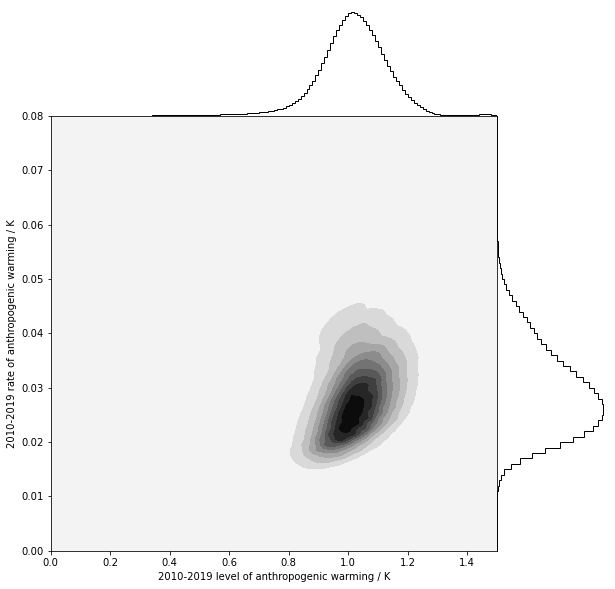

In [33]:
select_dataset = 'CW'

warming_level = np.load('../../aux/output-data/global-warming-index/results/T_2010-2019_'+select_dataset+'.npy')
warming_rate = np.load('../../aux/output-data/global-warming-index/results/dT_2010-2019_'+select_dataset+'.npy')

level_bins = np.arange(-0.2,1.8,0.01)
rate_bins = np.arange(-0.05,0.1,0.001)
AWI_binned = sp.stats.binned_statistic_2d(warming_level,warming_rate,None,'count',bins=[level_bins,rate_bins])

fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(5,5,hspace=0,wspace=0)
joint_ax = fig.add_subplot(gs[1:,:4])
margx_ax = fig.add_subplot(gs[0,:4])
margy_ax = fig.add_subplot(gs[1:,4])

joint_ax.contourf((AWI_binned.x_edge[:-1]+AWI_binned.x_edge[1:])/2,
             (AWI_binned.y_edge[:-1]+AWI_binned.y_edge[1:])/2,
             AWI_binned.statistic.T/AWI_binned.statistic.max(),
             levels=np.linspace(0,1,11),
             cmap='binary')

margx_ax.hist(warming_level,bins=level_bins,color='k',histtype='step')
margy_ax.hist(warming_rate,bins=rate_bins,color='k',histtype='step',orientation='horizontal')

[a.set_xlim(0,1.5) for a in [joint_ax,margx_ax]]
[a.set_ylim(0,0.08) for a in [joint_ax,margy_ax]]

joint_ax.set_xlabel('2010-2019 level of anthropogenic warming / K')
joint_ax.set_ylabel('2010-2019 rate of anthropogenic warming / K year$^{-1}$')

margx_ax.set_axis_off()
margy_ax.set_axis_off()

## Appendix I. Natural warming index
Here we calculate the estimated natural contributions to the present level of warming, for comparison with the all-forcing CONSTRAINED ensemble.

In [2]:
## get temperature timeseries
nat_temps = xr.open_dataarray('../../aux/output-data/global-warming-index/nat_temperature.nc',chunks={'forcing_mem':100})
nat_T_2010_2019 = (nat_temps.sel(time=slice('2010','2019')).mean('time')-nat_temps.sel(time=slice('1850','1900')).mean('time')).astype(np.single)

In [3]:
## load scaling coefficients and compute level/rate (very memory intensive)

# 500 million member subsamples to start = 2GB on disk per quantity
sub_size = int(5e8)
subsamples={}
## HadCRUT5 subsample
subsamples['HadCRUT5_obs_mem'] = np.random.choice(5000*102*18*200,sub_size)
## HadCRUT4 subsample
subsamples['HadCRUT4_obs_mem'] = np.random.choice(5000*102*18*100,sub_size)
## CW subsample
subsamples['CW_obs_mem'] = np.random.choice(5000*102*18*99,sub_size)


for select_dataset in ['HadCRUT5','HadCRUT4','NOAA','GISTEMP','CW','BERKELEY']:
    nat_coefs = (xr.open_dataarray('../../aux/output-data/global-warming-index/nat_coefs_forc_'+select_dataset+'.nc',chunks={'forcing_mem':100}).astype(np.single)+\
                 xr.open_dataarray('../../aux/output-data/global-warming-index/nat_coefs_IV_'+select_dataset+'.nc',chunks={'forcing_mem':100}).astype(np.single))
    
    obsv_unc_source = nat_coefs.dims[0]
    
    np.save('../../aux/output-data/global-warming-index/results/T_2010-2019_'+select_dataset+'_nat.npy',(nat_T_2010_2019*nat_coefs).values.flatten()[subsamples[obsv_unc_source]])

mean natural contribution to the present-day warming level

In [7]:
np.mean([np.load(x).mean() for x in glob.glob('../../aux/output-data/global-warming-index/results/T*nat.npy')])

0.04074793